# Plotting with Marsilea

[Marsilea](https://github.com/Marsilea-viz/marsilea) is a visualization library that allows user to create composable visualization in a declarative way.

You can use it to create many scanpy plots with easy customization.

Let's first load the PBMC datdaset

In [1]:
import numpy as np
import scanpy as sc

pbmc = sc.datasets.pbmc3k_processed().raw.to_adata()
pbmc

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    obsp: 'distances', 'connectivities'

Define the cells and markers that we want to draw

In [2]:
cell_markers = {
    "CD4 T cells": ["IL7R"],
    "CD14+ Monocytes": ["CD14", "LYZ"],
    "B cells": ["MS4A1"],
    "CD8 T cells": ["CD8A"],
    "NK cells": ["GNLY", "NKG7"],
    "FCGR3A+ Monocytes": ["FCGR3A", "MS4A7"],
    "Dendritic cells": ["FCER1A", "CST3"],
    "Megakaryocytes": ["PPBP"],
}

cells, markers = [], []
for c, ms in cell_markers.items():
    cells += [c] * len(ms)
    markers += ms

uni_cells = list(cell_markers.keys())
cell_colors = [
    "#568564",
    "#FFF3A7",
    "#F72464",
    "#005585",
    "#9876DE",
    "#405559",
    "#58DADA",
    "#F85959",
]
cmapper = dict(zip(uni_cells, cell_colors))

Import Marsilea

In [3]:
import marsilea as ma
import marsilea.plotter as mp

# Heatmap

Here is the minimum example to create a heatmap with Marsilea, it does nothing besides create a heatmap. You can adjust the main plot size by setting `height` and `width`, the unit is inches.

We will start adding components to this main plot step by step.

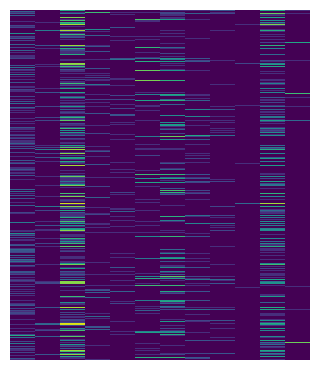

In [4]:
exp = pbmc[:, markers].X.toarray()

m = ma.Heatmap(exp, cmap="viridis", height=3.5, width=3)
m.render()

To replicate the scanpy heatmap, we can first divide the heatmap by cell types.

The `group_rows` can group heatmap by group labels, the first argument is used to label the row, the `order` define the display order of 
each cell types from top to bottom.

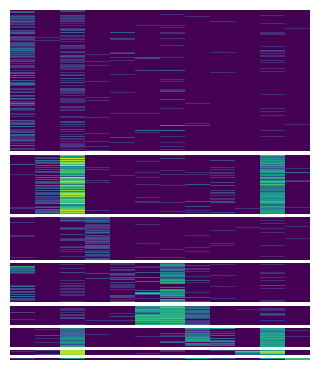

In [5]:
m.group_rows(pbmc.obs["louvain"], order=uni_cells)
m.render()

Now we can label each chunks with cell types and the columns with marker names.

You can use `add_left` or `add_*` to add a plotter to anyside of your main plot. In Marsilea, a plot instance is called plotter. 

When you add a plotter, you can easily adjust its size and the padding between adjcent plot using `size` and `pad`.

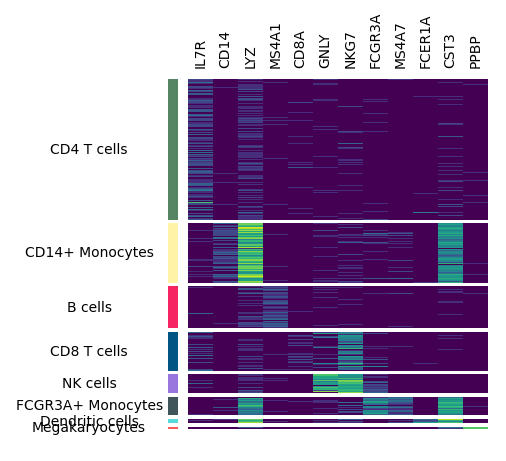

In [6]:
# Create plotters
chunk = mp.Chunk(uni_cells, rotation=0, align="center")
colors = mp.Colors(list(pbmc.obs["louvain"]), palette=cmapper)
label_markers = mp.Labels(markers)

# Add to the heatmap
m.add_left(colors, size=0.1, pad=0.1)
m.add_left(chunk)
m.add_top(label_markers, pad=0.1)
m.render()

You may want to add dendrogram to display the similarity among cell types.

You can use `add_dendrogram`, we will add it to the right side, but you can also add it to the left side if you want.

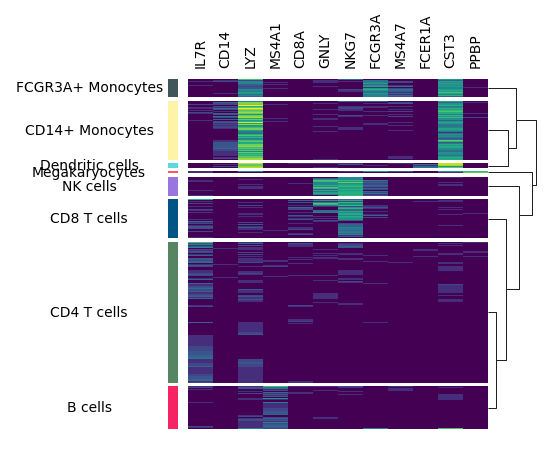

In [7]:
m.add_dendrogram("right", add_base=False)
m.render()

The legend is still mising, you can use `add_legends` to add all legends at once. Marsilea will automatically layout all the legends.

In the end, you can you `add_title` to add a title.

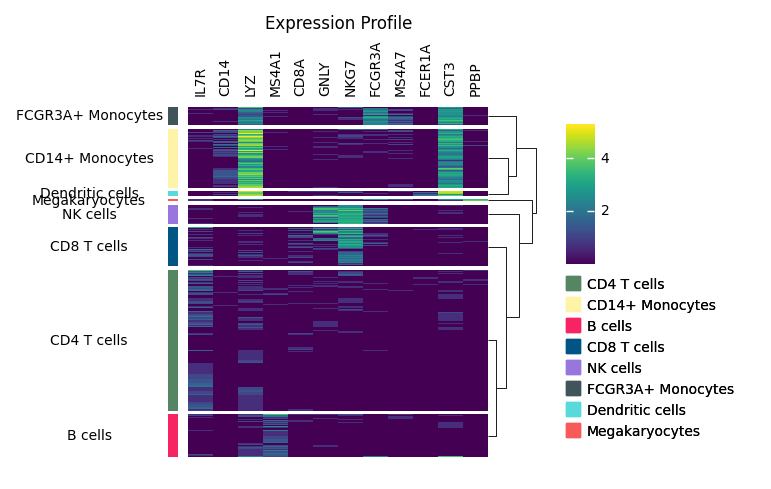

In [8]:
m.add_legends()
m.add_title("Expression Profile")
m.render()

OK, let's wrap up all the code in below. There are few things you should notice in Marsilea:

- Always call `render()` in the end to actually render the plot.
- The order of `add_*` operation decides the order of plotters. But `group_rows` and `group_cols` can be called anytime.

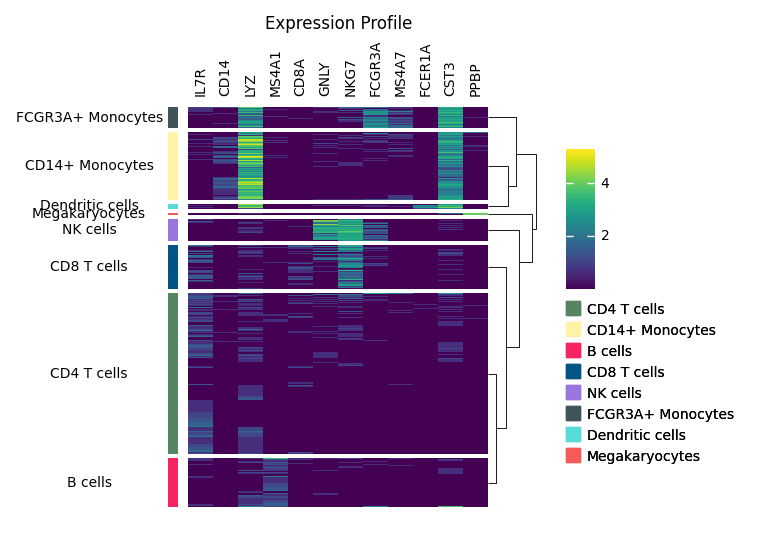

In [9]:
m = ma.Heatmap(exp, cmap="viridis", height=4, width=3)
m.group_rows(pbmc.obs["louvain"], order=uni_cells)

m.add_left(
    mp.Colors(list(pbmc.obs["louvain"]), palette=cmapper),
    size=0.1,
    pad=0.1,
)
m.add_left(mp.Chunk(uni_cells, rotation=0, align="center"))
m.add_top(mp.Labels(markers), pad=0.1)
m.add_dendrogram("right", add_base=False)

m.add_legends()
m.add_title("Expression Profile")
m.render()

Now that we've covered some basics of Marsilea, we'll see how it can be used to create custom plots similar to `scanpy`'s existing methods:

In [10]:
agg = sc.get.aggregate(pbmc[:, markers], by="louvain", func=["mean", "count_nonzero"])
agg.obs["cell_counts"] = pbmc.obs["louvain"].value_counts()
agg

AnnData object with n_obs × n_vars = 8 × 12
    obs: 'louvain', 'cell_counts'
    var: 'n_cells'
    layers: 'mean', 'count_nonzero'

In [11]:
agg_exp = agg.layers["mean"]
agg_count = agg.layers["count_nonzero"]
agg_cell_counts = agg.obs["cell_counts"].to_numpy()

# Matrixplot

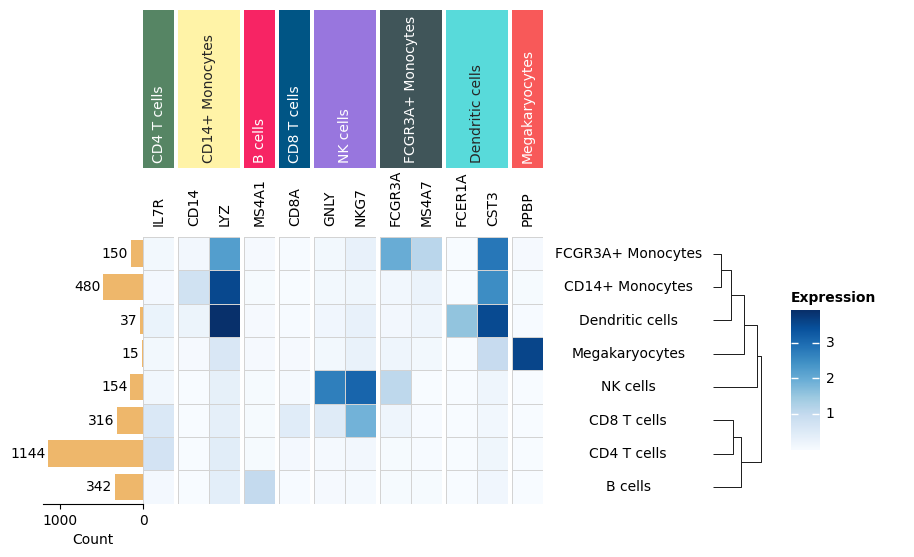

In [12]:
h, w = agg_exp.shape

m = ma.Heatmap(
    agg_exp,
    height=h / 3,
    width=w / 3,
    cmap="Blues",
    linewidth=0.5,
    linecolor="lightgray",
    label="Expression",
)
m.add_right(mp.Labels(agg.obs["louvain"], align="center"), pad=0.1)
m.add_top(mp.Labels(markers), pad=0.1)
m.group_cols(cells, order=uni_cells)
m.add_top(mp.Chunk(uni_cells, fill_colors=cell_colors, rotation=90))
m.add_left(mp.Numbers(agg_cell_counts, color="#EEB76B", label="Count"))
m.add_dendrogram("right", pad=0.1)
m.add_legends()
m.render()

# Dot plot

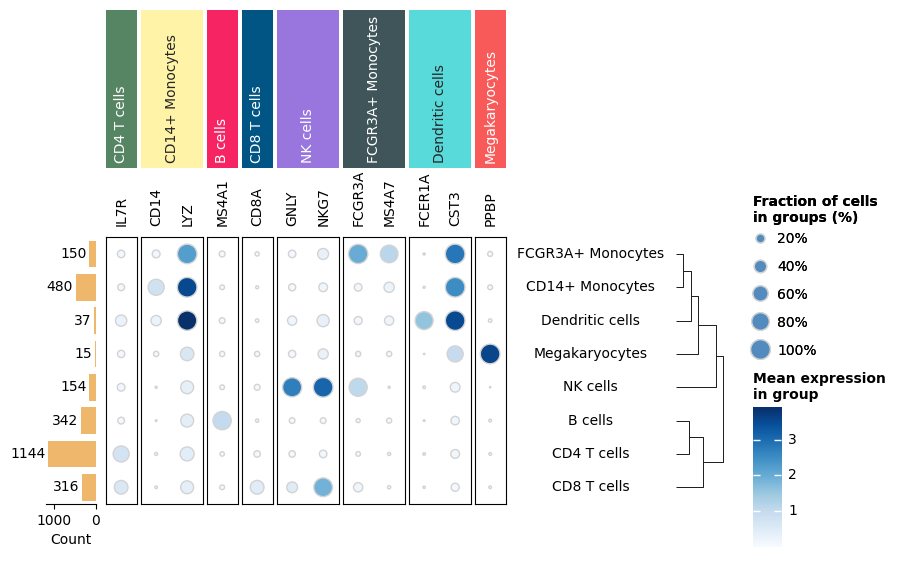

In [13]:
size = agg_count / agg_cell_counts[:, np.newaxis]
m = ma.SizedHeatmap(
    size=size,
    color=agg_exp,
    cluster_data=size,
    height=h / 3,
    width=w / 3,
    edgecolor="lightgray",
    cmap="Blues",
    size_legend_kws=dict(
        colors="#538bbf",
        title="Fraction of cells\nin groups (%)",
        labels=["20%", "40%", "60%", "80%", "100%"],
        show_at=[0.2, 0.4, 0.6, 0.8, 1.0],
    ),
    color_legend_kws=dict(title="Mean expression\nin group"),
)

m.add_top(mp.Labels(markers), pad=0.1)
m.add_top(mp.Chunk(uni_cells, fill_colors=cell_colors, rotation=90))
m.group_cols(cells, order=uni_cells)

m.add_right(mp.Labels(agg.obs["louvain"], align="center"), pad=0.1)
m.add_left(
    mp.Numbers(agg_cell_counts, color="#EEB76B", label="Count"), size=0.5, pad=0.1
)
m.add_dendrogram("right", pad=0.1)
m.add_legends()
m.render()

# Tracksplot

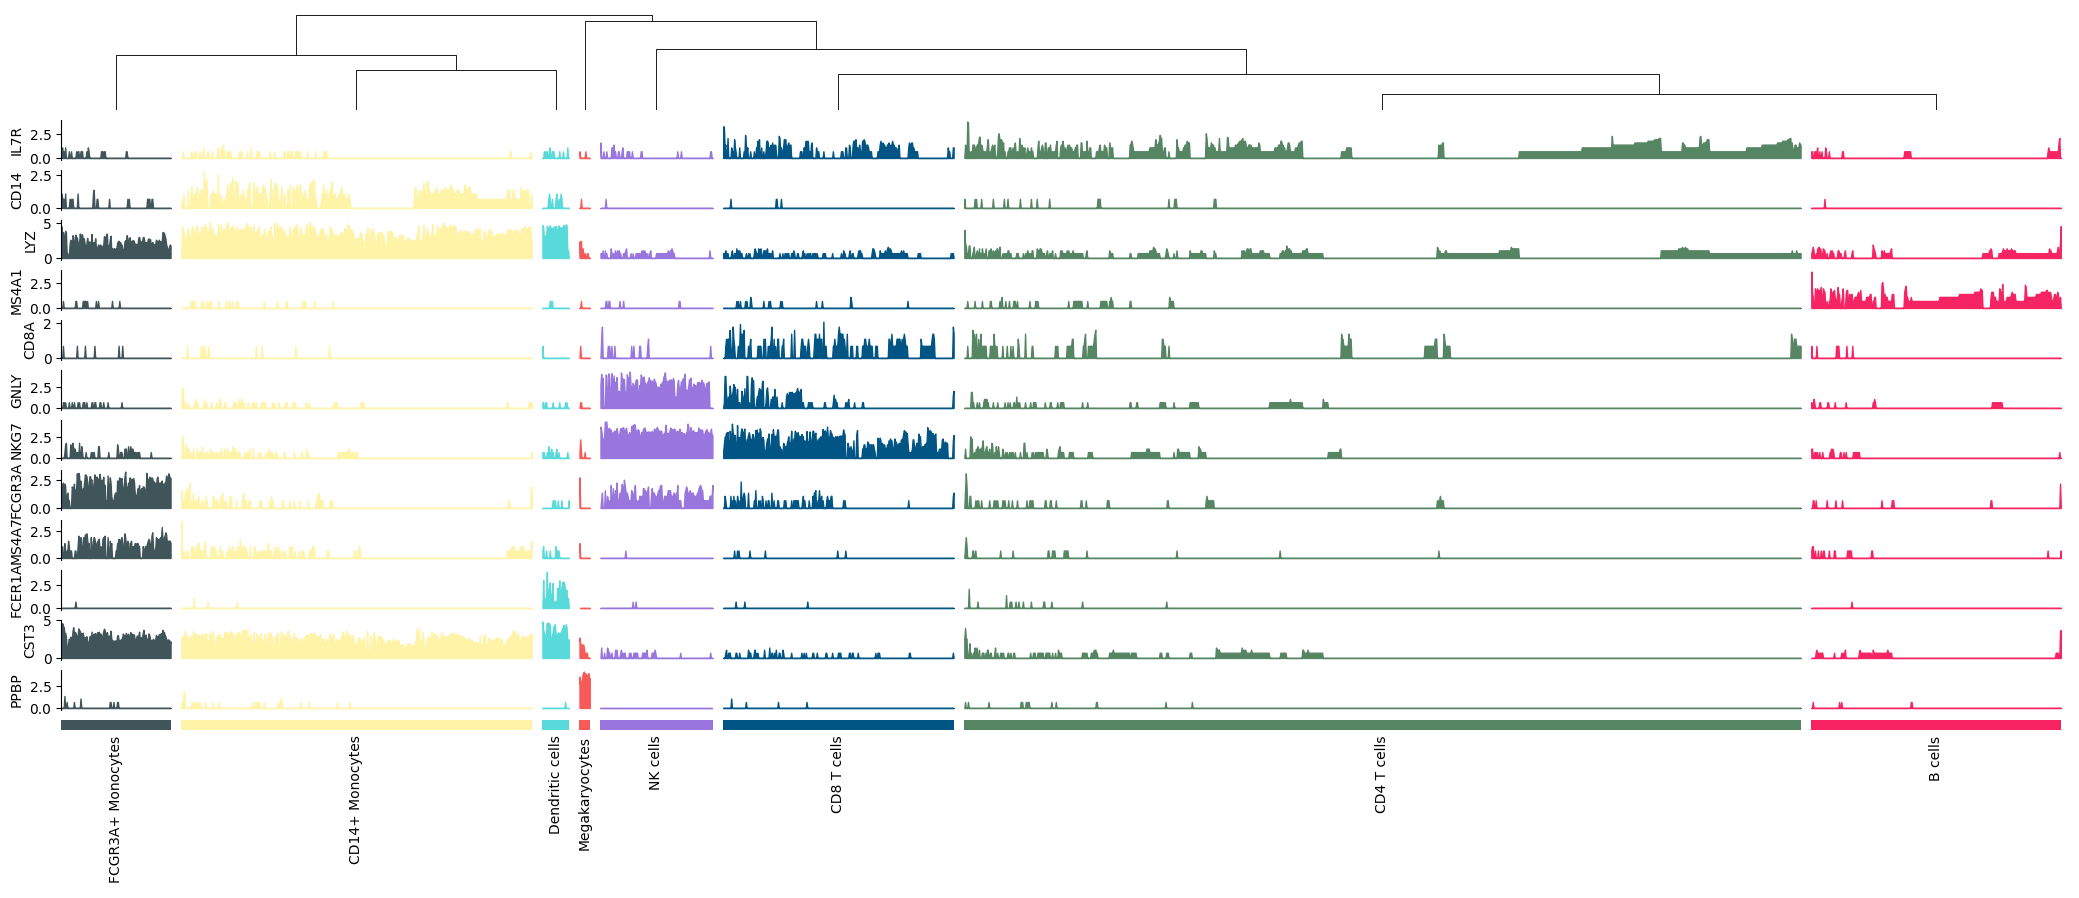

In [14]:
tp = ma.ZeroHeightCluster(exp.T, width=20)
tp.group_cols(pbmc.obs["louvain"], order=uni_cells, spacing=0.005)
tp.add_dendrogram("top", add_base=False, size=1)
for row, gene_name in zip(exp.T, markers):
    area = mp.Area(
        row,
        add_outline=False,
        alpha=1,
        label=gene_name,
        group_kws={"color": cell_colors},
    )
    tp.add_bottom(area, size=0.4, pad=0.1)
tp.add_bottom(mp.Colors(pbmc.obs["louvain"], palette=cmapper), size=0.1, pad=0.1)
tp.add_bottom(mp.Chunk(uni_cells, rotation=90))
tp.render()

# More information

Futhrer plots, like stacked violin, are possible with Marsilea by creating new plotter. [See Marsilea's documention to learn how](https://marsilea.readthedocs.io/en/stable/tutorial/new_renderplan.html).



In [15]:
import session_info

session_info.show(dependencies=True)